In [1]:
import sys
from glob import glob
from os import path as osp
from datetime import datetime
from tqdm import tqdm
from skimage import io, transform
from matplotlib import pyplot as plt
import numpy as np
from math import sqrt
from statistics import mean
# torch imports
import torch
from torchvision import transforms
from torch.utils.data.dataloader import DataLoader

# root path of project
from os import path as osp
import sys

# get root directory
import re
reg = '^.*/AquaPose'
project_root = re.findall(reg, osp.dirname(osp.abspath(sys.argv[0])))[0]
sys.path.append(project_root)

from lib.dataset.PoseDataset import PoseDataset
from lib.dataset.CycleDataset import CycleDataset

from lib.models.keypoint_rcnn import get_resnet50_pretrained_model

# utils
from lib.utils.slack_notifications import slack_message
from lib.utils.select_gpu import select_best_gpu
from lib.utils.rmsd import kabsch_rmsd, kabsch_rotate, kabsch_weighted_rmsd, centroid, centroid_weighted, rmsd, rmsd_weighted, kabsch

from lib.eval.pck import pck

# references import
# source: https://github.com/pytorch/vision/tree/master/references/detection
from references.engine import train_one_epoch, evaluate
from references.utils import collate_fn

from references.transforms import RandomHorizontalFlip

from lib.matching.matching import *
from lib.utils.visual_utils import *

## Model

In [2]:
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
cpu = torch.device('cpu')
print(device)
print(cpu)

weight_dir = osp.join(project_root, 'weights')
weight_files = glob(osp.join(weight_dir,'*'))
model = get_resnet50_pretrained_model()
for i, f in enumerate(weight_files):
    print('{}, {}'.format(i,f))
model.load_state_dict(torch.load(weight_files[0], map_location=torch.device('cpu')))

_ = model.to(device)
_ = model.eval()

cuda:0
cpu
0, /AquaPose/AquaPose/weights/_01-04-2020-17-12_epoch29-30_min_val_loss_3.673452949523926.wth
1, /AquaPose/AquaPose/weights/_16-03-2020-14-30_epoch9-10.wth
2, /AquaPose/AquaPose/weights/6_freestyle_ds_20-03-2020-10-00_epoch39-40.wth
3, /AquaPose/AquaPose/weights/_17-03-2020-18-01_epoch14-15.wth
4, /AquaPose/AquaPose/weights/_19-03-2020-07-47_epoch99-100.wth
5, /AquaPose/AquaPose/weights/_15-03-2020-22-39_epoch99-100.wth
6, /AquaPose/AquaPose/weights/_15-03-2020-21-39_epoch39-40.wth
7, /AquaPose/AquaPose/weights/_15-03-2020-21-32_epoch9-10.wth
8, /AquaPose/AquaPose/weights/_16-03-2020-11-06_epoch49-50.wth
9, /AquaPose/AquaPose/weights/ds_1_2_3_4_25-03-2020-16-48_epoch59-60_min_val_loss_10000.wth


In [3]:

train_dirs = [osp.join(project_root,'data/vzf/freestyle/freestyle_1'), osp.join(project_root,'data/vzf/freestyle/freestyle_2'), osp.join(project_root,'data/vzf/freestyle/freestyle_3'), osp.join(project_root,'data/vzf/freestyle/freestyle_4')]

test_dirs = [osp.join(project_root,'data/vzf/freestyle/freestyle_9'), osp.join(project_root,'data/vzf/freestyle/freestyle_10'), osp.join(project_root,'data/vzf/freestyle/freestyle_11'),osp.join(project_root,'data/vzf/freestyle/freestyle_12'), osp.join(project_root,'data/vzf/freestyle/freestyle_13'), osp.join(project_root,'data/vzf/freestyle/freestyle_14')] 

train_datasets = [PoseDataset([dir], train = False, cache_predictions=True) for dir in train_dirs]
test_pose_datasets = [PoseDataset([dir], train = False, cache_predictions=True) for dir in test_dirs]
test_cycle_datasets = [CycleDataset([dir], cache_predictions=True, max_dist=100) for dir in test_dirs]

anchor_dataset = PoseDataset([osp.join(project_root,'data/vzf/freestyle/freestyle_1')], train=False, cache_predictions=True)
anchor_ids = [x for x in range(17,81,1)]
anchor_dataset_male = torch.utils.data.Subset(anchor_dataset, anchor_ids)

anchor_dataset_female = PoseDataset([osp.join(project_root,'data/vzf/freestyle/freestyle_12')], train=False, cache_predictions=True)

anchor_datasets = [anchor_dataset_male, anchor_dataset_female]

anchor_ids = [0, 0, 0, 0,0,0]

In [4]:
test_pose_datasets_matching = [PoseDataset([dir], train = False, cache_predictions=True) for dir in test_dirs]
test_pose_datasets_mle = [PoseDataset([dir], train = False, cache_predictions=True) for dir in test_dirs]

In [5]:
for ds in test_pose_datasets:
    ds.predict_all(model)
for ds in test_pose_datasets_matching:
    ds.predict_all(model)
for ds in test_pose_datasets_mle:
    ds.predict_all(model)


100%|██████████| 12/12 [00:01<00:00,  7.56it/s]


In [6]:
for ds in test_cycle_datasets:
    for i in tqdm(range(0,len(ds))):
        ds.predict(model, i)

100%|██████████| 439/439 [01:00<00:00,  7.30it/s]


In [7]:
img_name_to_index_list = [pd.get_image_name_to_index() for pd in test_pose_datasets] 


In [8]:

flipped_transmat = build_transmat(2, [.95,.05])

## Loop over all corresponding datasets and do matching one per one so that image names and indexes point to the correct dataset

In [9]:
print(test_cycle_datasets[0].sequences)

[[0, 568], [568, 924]]


In [10]:

for pd, pd_match, pd_mle, cd, img_name_to_index, anchor_id in zip(test_pose_datasets, test_pose_datasets_matching, test_pose_datasets_mle, test_cycle_datasets, img_name_to_index_list, anchor_ids):

    # select anchor dataset
    anchor_dataset = anchor_datasets[anchor_id]

    #transmission probability
    transmat = build_transmat(len(anchor_dataset), probs=[0.25,0.30,0.20,0.15,0.05,0.05])

    # get observations, obersation likelihoods...
    obs_lik_list, observations_list, flipped_list= get_observation_likelihood(model, cd, anchor_dataset, max_stride=3, device=device)


    mls_list = []
    for obs_lik, obs, flipped_mat, seq in zip(obs_lik_list, observations_list, flipped_list, cd.sequences):

        mls = viterbi_path(np.array([1.0/len(anchor_dataset)]*len(anchor_dataset)), transmat, obs_lik)
        mls_list.append(mls)

        # also get most likely sequence for being flipped or not
        flipped_observed = [flipped_mat[mls[i]][i] for i in range(0, len(mls))]
        obslik_flipped = [[ .75 - (.5 * flipped_observed[i]) for i in range(0,len(mls))]]
        obslik_flipped += [[ 1 - obslik_flipped[0][i] for i in range(0,len(mls))]]
        obslik_flipped = np.array(obslik_flipped)
      

        mls_flipped = viterbi_path([.5,.5], flipped_transmat, obslik_flipped)

        #store sequence of anchor pose in cycle dataset
        cd.obs += [obs]
        cd.mls += [mls]

        # for num, _ in enumerate(obs):
        #     print('obs {}: {}'.format(num, np.array(obs_lik)[:,num]))

        for obs_id, (img, match_anchor, mle_anchor) in tqdm(enumerate(zip(range(seq[0],seq[1]), obs, mls))):
            _, target = cd[img]
            image_name = int(target['img'].split('/')[-1].split('.')[0])
            match_warped_anchor, ax = warp_anchor_on_pred(model, cd, img, anchor_dataset, match_anchor, True if mls_flipped[obs_id] else False)
            mle_warped_anchor, ax = warp_anchor_on_pred(model, cd, img, anchor_dataset, mle_anchor, True if mls_flipped[obs_id] else False)
            if image_name in img_name_to_index.keys():
                #print('{}: caching corrected pose'.format(image_name))
                pd_match.prediction_cache_corrected[img_name_to_index[image_name]] = match_warped_anchor
                pd_mle.prediction_cache_corrected[img_name_to_index[image_name]] = mle_warped_anchor
            #plt.show()
            plt.clf()

100%|██████████| 356/356 [12:14<00:00,  2.06s/it]
568it [02:06,  4.49it/s]
356it [01:25,  4.14it/s]
100%|██████████| 500/500 [17:12<00:00,  2.06s/it]
500it [01:51,  4.47it/s]
100%|██████████| 284/284 [09:48<00:00,  2.07s/it]
478it [01:46,  4.49it/s]
284it [01:08,  4.13it/s]
100%|██████████| 384/384 [13:05<00:00,  2.05s/it]
270it [01:00,  4.45it/s]
384it [01:31,  4.19it/s]
100%|██████████| 245/245 [08:28<00:00,  2.08s/it]
395it [01:28,  4.48it/s]
245it [00:59,  4.12it/s]
100%|██████████| 303/303 [10:27<00:00,  2.07s/it]
136it [00:30,  4.51it/s]
303it [01:13,  4.11it/s]


<Figure size 432x288 with 0 Axes>

In [3]:
pose_metric = pck(test_pose_datasets)
pose_matching_metric = pck(test_pose_datasets_matching)
pose_mle_metric = pck(test_pose_datasets_mle)

pck_score = pose_metric.score_per_keypoint(model,thresholds=[x/100 for x in range(0,55,5)], corrected=False)
inversion_error =  pose_metric.inversion_errors(model, thresholds=[x/100 for x in range(0,55,5)], corrected=False)

pck_score_matching = pose_matching_metric.score_per_keypoint(model, thresholds=[x/100 for x in range(0,55,5)], corrected=True)
inversion_error_matching =  pose_matching_metric.inversion_errors(model, thresholds=[x/100 for x in range(0,55,5)], corrected=True)

pck_score_mle = pose_mle_metric.score_per_keypoint(model, thresholds=[x/100 for x in range(0,55,5)], corrected=True)
inversion_error_mle =  pose_mle_metric.inversion_errors(model, thresholds=[x/100 for x in range(0,55,5)], corrected=True)



NameError: name 'pck' is not defined

In [12]:
thresholds=[x/100 for x in range(0,55,5)]
print(thresholds)

[0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]


## PCK

In [2]:
pck_score_merged = [0.5 * np.array([s for s in pck_score[joint]]) + 0.5 * np.array([s for s in pck_score[joint +1]]) for joint in range(1,12,2)]
inversion_error_merged = [0.5 * np.array([s for s in inversion_error[joint]]) + 0.5 * np.array([s for s in inversion_error[joint +1]]) for joint in range(1,12,2)]
plt.plot(thresholds, pck_score[0], label='head')

joint_groups = ['shoulders', 'elbows', 'wrists', 'hips', 'knees', 'ankles']
for scores, joint in zip(pck_score_merged, joint_groups):
    plt.plot(thresholds, scores, label=joint)
plt.legend()
plt.xlabel('threshold')
plt.ylabel('PCK@threshold')
plt.show()

joint_groups = ['shoulders', 'elbows', 'wrists', 'hips', 'knees', 'ankles']
for scores, joint in zip(inversion_error_merged, joint_groups):
    plt.plot(thresholds, scores, label=joint)
plt.legend()
plt.xlabel('threshold')
plt.ylabel('inversion')
plt.show()

inversion_02 = [inversion_joint[4] for inversion_joint in inversion_error_merged]
plt.bar([x for x in range(0, len(joint_groups))], inversion_02, tick_label=joint_groups, color=['#ff7f0e', 'g', 'red', '#9467bd', '#6c564b', '#e377c2'])
plt.ylim((0.0, 1.0))
plt.ylabel('percentage of inversion errors')
plt.show()

joint_groups = ['Shoulders', 'Elbows', 'Wrists', 'Hips', 'Knees', 'Ankles']
print('{} & {} \\\\'.format('Head', ' & '.join([str(round(i,2)) for i in pck_score[0][2::2]])))
for joint, j in zip(joint_groups, pck_score_merged):
    print('{} & {}  \\\\ '.format(joint, ' & '.join([str(round(i,2)) for i in j[2::2]])))

NameError: name 'np' is not defined

## PCK matching

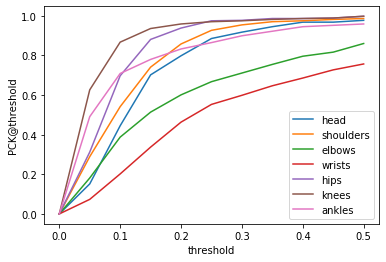

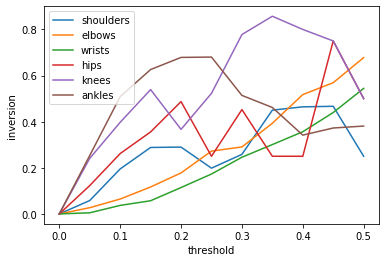

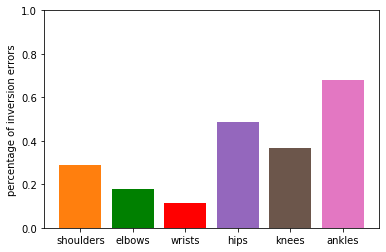

Head & 0.92 & 0.95 & 0.97 & 0.97 & 0.97 \\
Shoulders & 0.54 & 0.86 & 0.95 & 0.97 & 0.99  \\ 
Elbows & 0.39 & 0.6 & 0.71 & 0.8 & 0.86  \\ 
Wrists & 0.2 & 0.46 & 0.6 & 0.69 & 0.76  \\ 
Hips & 0.7 & 0.94 & 0.98 & 0.99 & 1.0  \\ 
Knees & 0.87 & 0.96 & 0.97 & 0.99 & 1.0  \\ 
Ankles & 0.71 & 0.83 & 0.9 & 0.94 & 0.96  \\ 


In [14]:
pck_score_merged = [0.5 * np.array([s for s in pck_score_matching[joint]]) + 0.5 * np.array([s for s in pck_score_matching[joint +1]]) for joint in range(1,12,2)]
inversion_error_merged = [0.5 * np.array([s for s in inversion_error_matching[joint]]) + 0.5 * np.array([s for s in inversion_error_matching[joint +1]]) for joint in range(1,12,2)]
plt.plot(thresholds, pck_score_matching[0], label='head')

joint_groups = ['shoulders', 'elbows', 'wrists', 'hips', 'knees', 'ankles']
for scores, joint in zip(pck_score_merged, joint_groups):
    plt.plot(thresholds, scores, label=joint)
plt.legend()
plt.xlabel('threshold')
plt.ylabel('PCK@threshold')
plt.show()

joint_groups = ['shoulders', 'elbows', 'wrists', 'hips', 'knees', 'ankles']
for scores, joint in zip(inversion_error_merged, joint_groups):
    plt.plot(thresholds, scores, label=joint)
plt.legend()
plt.xlabel('threshold')
plt.ylabel('inversion')
plt.show()

inversion_02 = [inversion_joint[4] for inversion_joint in inversion_error_merged]
plt.bar([x for x in range(0, len(joint_groups))], inversion_02, tick_label=joint_groups, color=['#ff7f0e', 'g', 'red', '#9467bd', '#6c564b', '#e377c2'])
plt.ylim((0.0, 1.0))
plt.ylabel('percentage of inversion errors')
plt.show()

joint_groups = ['Shoulders', 'Elbows', 'Wrists', 'Hips', 'Knees', 'Ankles']
print('{} & {} \\\\'.format('Head', ' & '.join([str(round(i,2)) for i in pck_score_matching[0][2::2]])))
for joint, j in zip(joint_groups, pck_score_merged):
    print('{} & {}  \\\\ '.format(joint, ' & '.join([str(round(i,2)) for i in j[2::2]])))

In [15]:
## PCK MLE

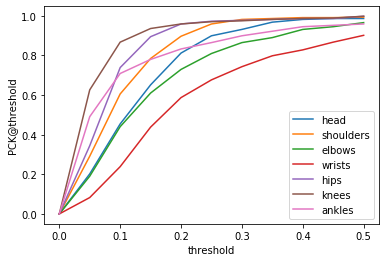

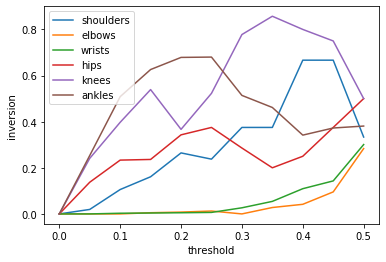

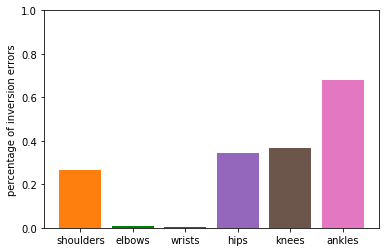

Head & 0.92 & 0.95 & 0.97 & 0.97 & 0.97 \\
Shoulders & 0.61 & 0.9 & 0.98 & 0.99 & 0.99  \\ 
Elbows & 0.44 & 0.73 & 0.86 & 0.93 & 0.97  \\ 
Wrists & 0.24 & 0.59 & 0.74 & 0.83 & 0.9  \\ 
Hips & 0.74 & 0.96 & 0.98 & 0.99 & 1.0  \\ 
Knees & 0.87 & 0.96 & 0.97 & 0.99 & 1.0  \\ 
Ankles & 0.71 & 0.83 & 0.9 & 0.94 & 0.96  \\ 


In [16]:
pck_score_merged = [0.5 * np.array([s for s in pck_score_mle[joint]]) + 0.5 * np.array([s for s in pck_score_mle[joint +1]]) for joint in range(1,12,2)]
inversion_error_merged = [0.5 * np.array([s for s in inversion_error_mle[joint]]) + 0.5 * np.array([s for s in inversion_error_mle[joint +1]]) for joint in range(1,12,2)]
plt.plot(thresholds, pck_score_mle[0], label='head')

joint_groups = ['shoulders', 'elbows', 'wrists', 'hips', 'knees', 'ankles']
for scores, joint in zip(pck_score_merged, joint_groups):
    plt.plot(thresholds, scores, label=joint)
plt.legend()
plt.xlabel('threshold')
plt.ylabel('PCK@threshold')
plt.show()

joint_groups = ['shoulders', 'elbows', 'wrists', 'hips', 'knees', 'ankles']
for scores, joint in zip(inversion_error_merged, joint_groups):
    plt.plot(thresholds, scores, label=joint)
plt.legend()
plt.xlabel('threshold')
plt.ylabel('inversion')
plt.show()

inversion_02 = [inversion_joint[4] for inversion_joint in inversion_error_merged]
plt.bar([x for x in range(0, len(joint_groups))], inversion_02, tick_label=joint_groups, color=['#ff7f0e', 'g', 'red', '#9467bd', '#6c564b', '#e377c2'])
plt.ylim((0.0, 1.0))
plt.ylabel('percentage of inversion errors')
plt.show()

joint_groups = ['Shoulders', 'Elbows', 'Wrists', 'Hips', 'Knees', 'Ankles']
print('{} & {} \\\\'.format('Head', ' & '.join([str(round(i,2)) for i in pck_score_mle[0][2::2]])))
for joint, j in zip(joint_groups, pck_score_merged):
    print('{} & {}  \\\\ '.format(joint, ' & '.join([str(round(i,2)) for i in j[2::2]])))

In [17]:
# for id, (img,target) in enumerate(anchor_datasets[0]):
#     ref_kps = target['keypoints'][0].detach().numpy()
#     ref_kps = merge_head(ref_kps)

#     print('id {}'.format(id))
#     print(target['image_id'])
#     get_image_with_kps_skeleton(img, [ref_kps])
#     plt.gca().invert_xaxis()
#     plt.show()

In [ ]:
# count = 0
# for ds, ds_match, anchor_id in zip(test_pose_datasets_mle, test_pose_datasets_matching, anchor_ids):
#     anchor_dataset = anchor_datasets[anchor_id]
#     for idx, (img, target) in enumerate(ds):
#         # if ds.prediction_cache_corrected[idx] is None:
#         #     count += 1
#         #     continue
#         _, pred, scores = ds.predict(model,idx, corrected=False)
#         ref_kps = merge_head(target['keypoints'][0].detach().numpy())
        
#         match_inds, match_scores, match_flipped = get_most_similar_ind_and_scores(pred, scores, anchor_dataset, num=5, translat_weights=T_WEIGHTS, kp_weights=KP_WEIGHTS)

#         pred = merge_head(pred)
#         scores = merge_head(scores)
#         # warped = ds.predict(model, idx, corrected=True)
#         # matched = ds_match.predict(model, idx, corrected=True)
#         filter_ind = np.array([x for x in range(0,13)])[scores > 0]
#         filter_ind = np.append(filter_ind, np.array([9,10,11,12]))

#         print('ID {}'.format(idx))
#         print('original')
#         plt.imshow(tensor_to_numpy_image(img))
#         plt.axis('off')
#         plt.grid(b=None)
#         plt.gca().invert_xaxis()
#         plt.show()

#         print('prediction:')
#         get_image_with_kps_skeleton(img, [pred], filter_ind=filter_ind, color_list=['r'])
#         plt.gca().invert_xaxis()
#         plt.show()
        
#         # print('mle result: ')
#         # get_image_with_kps_skeleton(img, [warped])
#         # plt.gca().invert_xaxis()
#         # plt.show()
#         print('gt pose: ')
#         get_image_with_kps_skeleton(img, [ref_kps], color_list=['lime'])
#         plt.gca().invert_xaxis()
#         plt.show()

#         print('matched')
#         for match_ind, match_flip in zip(match_inds, match_flipped):
#             print('match_id {}'.format(match_ind))
#             match_warped_anchor, ax = warp_anchor_on_pred(model, ds, idx, anchor_dataset, match_ind, True if match_flip else False)
            
#             get_image_with_kps_skeleton(img, [match_warped_anchor])
#             plt.gca().invert_xaxis()
#             plt.show()
        
# print(count)

## Stroke Rate extraction

In [ ]:
from statistics import mean

# transform into binary list
def sawtooth_crash(seq_list, crash_height):
    crashes = []
    for seq in seq_list:
        #Search crash to start sequence or if current anchor pose index is low enough assume that crash just happened
        if seq[0] < 30:
            start = 0
        else:
            start = len(seq) - 1
            for i in range(0, len(seq) - 1):
                if seq[i] - seq[i+1] > crash_height:
                    start = i
                    break
        seq_crashes = [1]
        for i in range(start + 1, len(seq) - 1):
            if seq[i] - seq[i+1] > crash_height:
                seq_crashes.append(1)
            else:
                seq_crashes.append(0)
        crashes.append(seq_crashes)
    return crashes

def get_stroke_durations(seq_list, crash_height, fps_list):
        crashes = sawtooth_crash(seq_list, crash_height)
        # return per sequence a list with half stroke (1 phase) durations
        stroke_durations = []
        for seq, fps in zip(crashes, fps_list):
            seq_phase_durations = []
            num_frames = 1
            for item in seq[1:]:
                if item == 1:
                    seq_phase_durations.append(num_frames / fps)
                    num_frames = 1
                else: 
                    num_frames += 1
            #count last stroke if approaching sawtooth
            if num_frames > crash_height:
                seq_phase_durations.append(num_frames / fps)
            stroke_durations.append(seq_phase_durations)
        
        return stroke_durations

def get_mean_stroke_rate(seq_list, crash_height, fps_list):
    stroke_durations = get_stroke_durations(seq_list, crash_height, fps_list)
    flatten = lambda l: [item for sublist in l for item in sublist]
    stroke_durations = flatten(stroke_durations)
    return 60.0 / mean(stroke_durations)

In [ ]:
# fps_set contains fps for ech sequence
fps_set = [25,25]

In [ ]:
mean_stroke_rate_predicted = get_mean_stroke_rate(mls_list, 30, fps_set)
stroke_durations = get_stroke_durations(mls_list, 30, fps_set)
print('phase durations: {}'.format(stroke_durations))
print('mean stroke rate: {}'.format(mean_stroke_rate_predicted))


In [ ]:
phase_durations = test_cycle_datasets[0].get_phase_durations(fps_set)
mean_stroke_rate = test_cycle_datasets[0].get_mean_stroke_rate(fps_set)
print('phase durations: {}'.format(phase_durations))
print('mean stroke rate: {}'.format(mean_stroke_rate))

In [ ]:
def get_mean_stroke_rate(self, fps_list):
    phase_durations = get_phase_durations(self,fps_list)

    flatten = lambda l: [item for sublist in l for item in sublist]
    phase_durations = flatten(phase_durations)

    mean_stroke_duration = mean(phase_durations) * 2

    return 60.0 / mean_stroke_duration

# in seconds
def get_phase_durations(self, fps_list):
    # return per sequence a list with half stroke (1 phase) durations
    phase_durations = []
    for seq, fps in zip(self.sequences, fps_list):
        seq_phase_durations = []
        num_frames = 1
        for item_id in range(seq[0]  + 1, seq[1]):
            if self.items[item_id]['offset'] == 0:
                seq_phase_durations.append(num_frames / fps)
                num_frames = 1
            else:
                num_frames += 1
        phase_durations.append(seq_phase_durations)
        
    return phase_durations

In [ ]:
phase_offset = [[item_dict['offset']==0 for _, item_dict in torch.utils.data.Subset(test_cycle_datasets[-1], [i for i in range(seq[0], seq[1])]) if item_dict['phase'] != 'turn'] for seq in test_cycle_datasets[-1].sequences]



In [ ]:
phase_offset = [[1 if b else 0 for b in p] for p in phase_offset]


# plt.plot([x for x in range(0, len(mls))][1:201], mls[1:201])
# #plt.plot([x for x in range(0, len(mls))], obs)
# odd = 1
# for frame,stroke in enumerate(phase_offset[0]):
#     if frame > 201:
#         break
#     if stroke==1:
#         if odd == 1:
#             plt.axvline(x=frame, color='r')
#         odd = 1 - odd

# plt.xlabel('frame')
# plt.ylabel('anchor id')

for cd in test_cycle_datasets:
    phase_offset = [[item_dict['offset']==0 for _, item_dict in torch.utils.data.Subset(cd, [i for i in range(seq[0], seq[1])]) if item_dict['phase'] != 'turn'] for seq in cd.sequences]
    phase_offset = [[1 if b else 0 for b in p] for p in phase_offset]

    for seq_id, seq in enumerate(cd.sequences):
        x_range = [x for x in range(seq[0], seq[1])]
        plt.plot(x_range, cd.mls[seq_id])

        odd = 1
        for frame,stroke in enumerate(phase_offset[seq_id]):
            if stroke==1:
                if odd == 1:
                    plt.axvline(x=x_range[frame], color='r')
                odd = 1 - odd
        plt.ylabel('anchor ID')
        plt.xlabel('frame')
        plt.show()

## Get average error of stroke durations

In [ ]:
for cd in test_cycle_datasets:
    print('{},{}'.format(cd.sequences, cd.mls))

In [ ]:
# how many phases are taken together
intervals = [1, 2, 3, 4 ,5, 6]
errors = [[] for x in intervals]

fps_set = [50,50,50, 25 ,50 ,25]
for cycle_ds, fps, anchor_id in zip(test_cycle_datasets, fps_set, anchor_ids):
   
    anchor_dataset = anchor_datasets[anchor_id]

    # one fps entry per sequence
    fps_list = [fps for x in range(0,len(cycle_ds.sequences))]

    # gt phases durations
    # default per half stroke cycle so produce sum of two entries
    gt_durations = cycle_ds.get_phase_durations(fps_list)
    gt_durations_merged = []
    
    # for each sequence
    for gt_dur_seq in gt_durations:
        gt_durations_merged_seq = []
        for i in range(0, len(gt_dur_seq) - 1, 2):
            gt_durations_merged_seq += [gt_dur_seq[i] + gt_dur_seq[i + 1]]
        gt_durations_merged += [gt_durations_merged_seq]
    gt_durations = gt_durations_merged

    # dt phases durations
    dt_durations = get_stroke_durations(cycle_ds.mls, len(anchor_dataset)/2, fps_list)
    print(cycle_ds)
    print(gt_durations)
    print(dt_durations)
    
    for interval_id, interval in enumerate(intervals):
        for gt_seq, dt_seq in zip(gt_durations, dt_durations):
            #print(gt_seq)
            #print(dt_seq)
            #merge over interval
            gt_seq_interval = []
            dt_seq_interval = []
            for i in range(0, min(len(gt_seq),len(dt_seq)) - (interval - 1), interval):
                gt_seq_interval += [sum([gt_seq[i+j] for j in range(0, interval)])]
                dt_seq_interval += [sum([dt_seq[i+j] for j in range(0,interval)])]

            # get absolute difference
            abs_diff = np.array(gt_seq_interval) - np.array(dt_seq_interval)
            abs_diff = list(np.absolute(abs_diff))

            # append LIST to error list of interval
            errors[interval_id] += abs_diff




In [ ]:
averages = []
human_observer = []
for interval_error, interval in zip(errors, intervals):
    interval_error = np.array(interval_error)
    mean_val = np.mean(interval_error)/interval

    averages += [mean_val]
    human_observer += [0.106/interval]

plt.plot(intervals, averages, label='framework')
plt.plot(intervals, human_observer, label='manual timing')
plt.xticks([x for x in intervals])
plt.xlabel('strokes per interval')
plt.legend()
plt.ylabel('average stroke duration error (s)')